# CSC3831 Final Assessment - Part 2: Machine Learning



##Background

The **MNIST dataset** is a collection of 70,000 instances of labeled handwritten digits. The database is widely used to test the implementation of classifiers (*Baldominos et al., 2019*). The aim of these classifiers is to correctly identify the handwritten digit in each image which corresponds to the label. This coursework focuses on 4 different tasks to classify and process these digits.

##Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from joblib import parallel_backend
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

## 1. Load the MNIST dataset, visualise the first 20 digits, and print their corresponding labels

###1.1 Load MNIST dataset

In [3]:
# Run this to load the MNIST dataset
from sklearn.datasets import fetch_openml

X, y = fetch_openml(
    'mnist_784', version=1, return_X_y=True, parser='auto', as_frame=False
)

###1.2 Visualise the first 20 digits and their labels

I am loading the first 20 digits along with their labels to verify the accuracy and content of the dataset. It is important to understand the structure of the data and observe the variations in handwriting amoung the digits.

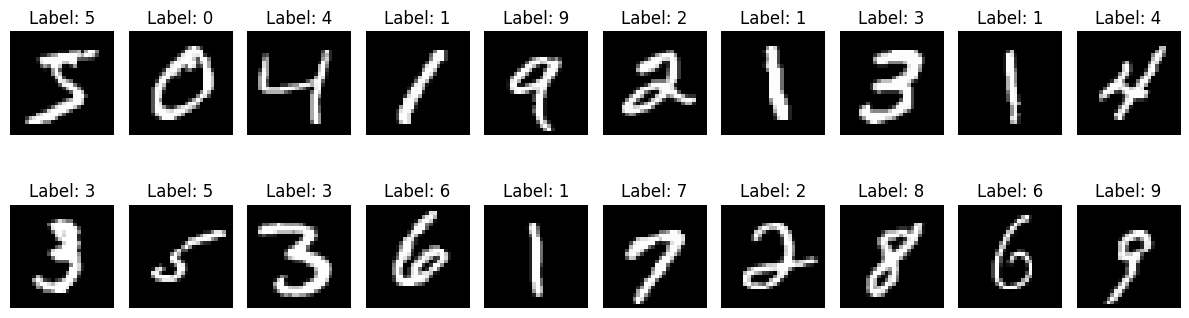

In [4]:
# Visualise the first 20 digits
fig, axes = plt.subplots(2, 10, figsize=(12, 4))
axes = axes.flatten()

# Loop through the first 20 samples
for i in range(20):
    image = X[i].reshape(28, 28)
    label = y[i]
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

After loading and visualising the first 20 digits and their corresponding labels, it is evident that the dataset contains clear and distinct handwritten digits with labels that accurately match their visual representation. From a human perspective, each number is generally distinguishable. However, some digits appear more distinct than others. For example, the 11th digit, which is a number three, is slightly less defined compared to other digits. This variability in clarity could pose challenges for a classifier, as subtle differences in handwriting styles may lead to misclassifications. This shows the importance of preparing the data carefully and choosing the right model to make sure the classifier works well.

## 2. Train a Logistic Regression classifier on this data, and report on your findings.

**Logistic Regression** is a supervised machine learning algorithm used for classification tasks, aiming to predict the probability that an instance belongs to a specific class. It is well-suited for the MNIST dataset, which consists of handwritten digits labeled with their correct corresponding values, enabling the model to evaluate its predictions and improve classification accuracy.

###2.1 Tune Hyperparameters

####2.1.1 Prepare Dataset

Before applying logistic regression I have first **normalised** the pixel values as the MNSIT dataset range from 0 to 255 meaning large feature values can dominate the gradient calculations, which slows down convergence (*Suhel et al., 2023*). By normalising these pixles from 0 to 1 it speeds up training and improves convergence.

In [5]:
# Normalise the pixel values to the range [0, 1]
X_normalised = X / 255.0

In addition to normalising the data, we can also **scale** it to further enhance model performance. Logistic Regression can be sensitive to the scale of input features, and when features have vastly different magnitudes, some parameters may dominate over others. This imbalance can make the optimisation process inefficient. Scaling ensures that all features contribute equally during training. Additionally, scaling improves convergence, allowing the model to reach an optimal solution more quickly (*Yogita, 2024*).

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_normalised)

The MNIST dataset is typically divided into two subsets: a training set with 60,000 images and a test set with 10,000 images. This separation enables the Logistic Regression model to be trained on the training set and its performance evaluated on the test set (*Puri, 2023*).

In [7]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=1/7, random_state=42)

We can check that the correct split has been made for the dataset into the two subsets

In [8]:
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (60000, 784), (60000,)
Test set shape: (10000, 784), (10000,)


In this case here the number 784 refers to the total number of features for each image in the MNIST dataset.

I created a subset of the MNIST dataset to evaluate my parameter grid, as training on the entire dataset may be time consuming. This approach allows me to experiment with different subset sizes to determine the optimal size that creates a balance between training time, weight sparsity, and accuracy. By testing with various subset sizes, I can identify the most efficient parameters that maintains good performance while ensuring reasonable training time.

In [9]:
X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=6000, random_state=42)

####2.1.2 Train Logistic Regression model

In [10]:
# Define the logistic regression model
log_model = LogisticRegression(max_iter=2000)

The parameters I have included in the grid aim to ensure weight sparsity and high accuracy. The L1 penalty encourages sparsity by driving some coefficients to zero, effectively performing feature selection. By testing different C values, we can find the optimal one to improve regularisation and prevent overfitting. I selected the SAGA solver because it works well with L1 regularisation and supports sparse solutions.

In [11]:
# Create a grid
param_grid = {
    'penalty': ['l1'],
    'C': [0.001, 0.01, 0.1],
    'solver': ['saga'],
}

To perform the grid search, I chose a 3-fold cross-validation because adding more folds significantly decreased the speed of the process, making it less feasible to explore different parameters in the grid. I also set `n_jobs=-`1 to enable parallel computation across all CPU cores, which speeds up the process. The use of `tqdm` ensures transparency by providing real-time feedback, which aids in monitoring and analyzing the progress of the hyperparameter tuning. This allows for more efficient tuning and better insights into the grid search.

In [12]:
# Set up Grid search
clf = GridSearchCV(log_model, param_grid, cv=3, verbose=10, n_jobs=-1)

with parallel_backend('threading'):
    # Include progress bar updates
    with tqdm(total=len(param_grid['penalty']) * len(param_grid['C']),
              desc="Grid Search Progress") as pbar:
        best_clf = clf.fit(X_train_subset, y_train_subset)
        pbar.update(1)

Grid Search Progress:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3; 1/3] START C=0.001, penalty=l1, solver=saga............................
[CV 2/3; 1/3] START C=0.001, penalty=l1, solver=saga............................
[CV 3/3; 1/3] START C=0.001, penalty=l1, solver=saga............................
[CV 1/3; 2/3] START C=0.01, penalty=l1, solver=saga.............................
[CV 1/3; 1/3] END C=0.001, penalty=l1, solver=saga;, score=0.115 total time=   0.8s
[CV 2/3; 2/3] START C=0.01, penalty=l1, solver=saga.............................
[CV 2/3; 1/3] END C=0.001, penalty=l1, solver=saga;, score=0.116 total time=   1.1s
[CV 3/3; 2/3] START C=0.01, penalty=l1, solver=saga.............................
[CV 3/3; 1/3] END C=0.001, penalty=l1, solver=saga;, score=0.116 total time=   1.9s
[CV 1/3; 3/3] START C=0.1, penalty=l1, solver=saga..............................
[CV 3/3; 2/3] END C=0.01, penalty=l1, solver=saga;, score=0.807 total time= 4.6min
[CV 2/3; 3/3] START C=0.1, penalty=l1, 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 2/3] END C=0.01, penalty=l1, solver=saga;, score=0.805 total time= 5.9min
[CV 3/3; 3/3] START C=0.1, penalty=l1, solver=saga..............................


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 2/3] END C=0.01, penalty=l1, solver=saga;, score=0.817 total time= 5.9min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3; 3/3] END C=0.1, penalty=l1, solver=saga;, score=0.889 total time= 8.3min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3; 3/3] END C=0.1, penalty=l1, solver=saga;, score=0.888 total time= 6.9min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3; 3/3] END C=0.1, penalty=l1, solver=saga;, score=0.896 total time= 8.5min


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [13]:
# Extract the best model
best_model = best_clf.best_estimator_

# Calculate weight sparsity
weights = best_model.coef_
sparsity = np.mean(weights == 0)

In [14]:
print(f'Best Parameters: {best_clf.best_params_}')
print(f'Accuracy on Test Set: {best_clf.score(X_test, y_test):.3f}')
print(f'Weight Sparsity: {sparsity:.3f}')

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Accuracy on Test Set: 0.893
Weight Sparsity: 0.777


The best parameters found for the logistic regression model were C=0.1, penalty = 'l1', and solver = 'saga'. With these settings, the model achieved an accuracy of 0.893 on the test set. The weight sparsity of 0.777 indicates that approximately 78% of the model's coefficients are zero, reflecting the effectiveness of the L1 regularisation in driving weights to zero, which promotes sparsity and aids in feature selection.

However, there were some limitations. The grid search was conducted on only a subset of 6,000 data points, as testing on the full dataset took a considerable amount of time and resulted in only a slight increase in accuracy. Despite this, the model was still able to achieve a robust performance with good weight sparsity on the smaller subset.

A similar issue arose with the maximum number of iterations. Some parameter combinations exceeded the maximum iterations allowed. However, increasing the number of iterations also significantly increased the runtime, which became a drawback of the model.

The achieved accuracy is slightly lower than the typical performance for logistic regression on the MNIST dataset, where the accuracy is usually around 91%. However, considering the trade-off between accuracy and weight sparsity, the accuracy of 0.893 was the best balance achieved with effective regularisation.

Through experimentation, it became clear that the L1 penalty, when paired with the 'saga' solver, was optimal for promoting weight sparsity. The selection of the C-value range was a more difficult parameter to define. A smaller C-value encouraged more coefficients to be driven to zero, enhancing sparsity. In contrast, larger C-values reduce regularisation, which can improve accuracy but may reduce sparsity. After testing various ranges, I found that values of C between 0.001 and 0.1 provided the best outcome, balancing both accuracy and weight sparsity effectively.

###2.1 Visualise classification vectors

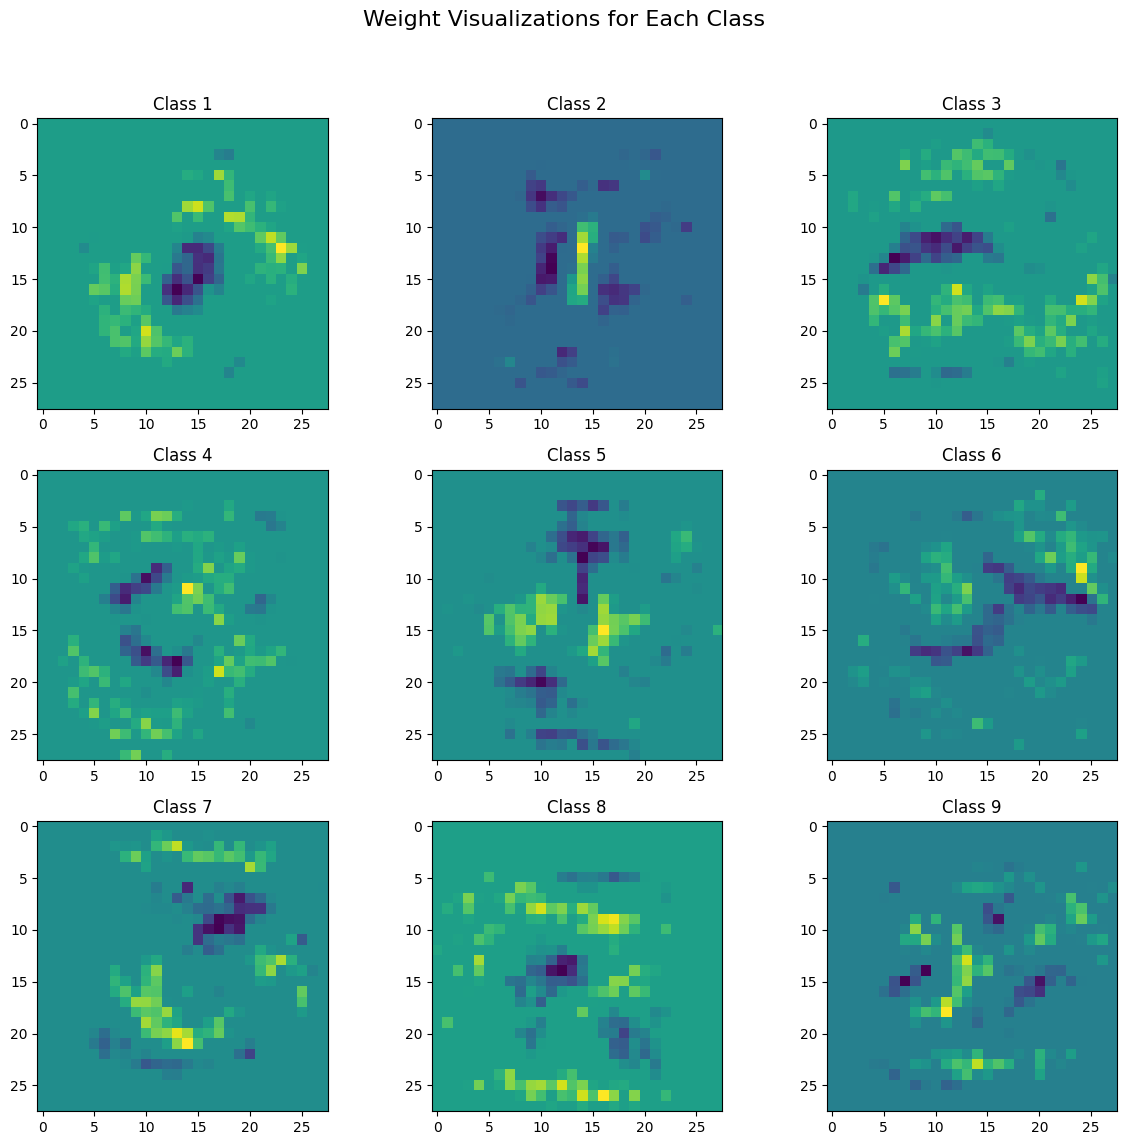

In [15]:
image_shape = (28, 28)

num_classes = len(weights)
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

fig.suptitle('Weight Visualizations for Each Class', fontsize=16)

# Plot classification visualisations
for i, coef in enumerate(weights[:rows * cols]):
    ax = axes[i // cols, i % cols]
    ax.set_title(f'Class {i+1}', fontsize=12)
    ax.imshow(coef.reshape(image_shape), cmap='viridis', interpolation='nearest')
    ax.axis('on')

for j in range(rows * cols):
    if j >= num_classes:
        axes[j // cols, j % cols].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

We can visualise the **classification vectors** to examine the features the model uses to distinguish between classes. Each classification vector represents a set of weights, where each weight corresponds to a pixel or feature in the input data. This visualisation reveals which pixels are most important for classifying each digit. For example, in the first class, the digit '0' shows dark central areas and round edges.

An improvement for these visualisations would be improved **weight sparsity**. When weights are sparse, the model focuses on the most important features, making it easier to identify which pixels are crucial for classifying each digit. This results in more distinct and interpretable classification vectors. Sparse weights help the model prioritise key features, offering clearer and more focused visualisations, allowing for better insights into the classification process.

##3. Use PCA to reduce the dimensionality of your training data.

Principal Component Analysis (PCA) is a method used in data analysis to reduce the dimensionality of datasets while keeping important information. It works by transforming the original variables into a new set of variables called principal components. These components are uncorrelated and arranged to capture as much of the variation in the data as possible, making it easier to analyse and visualise (*Analytics Vidhya, 2024*).

###3.1 Determine the number of components necessary to explain 80% of the variance

Before applying PCA, it is important to scale the data to ensure that all features contribute equally to the analysis. Features with larger ranges tend to dominate the variance, even if they are not the most important contributors to the data's structure. Scaling ensures that all features are treated equally, preventing bias in the results (*Keita, 2023*).

In [16]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=1/7, random_state=42)

In [17]:
# Create a scaled train and test set
X_train_scaled = StandardScaler().fit_transform(X2_train)
X_test_scaled = StandardScaler().fit_transform(X2_test)

In [18]:
# Perform PCA to reduce dimensionality
pca = PCA(n_components=0.80)
X_pca = pca.fit_transform(X2_train)
print(f'Total number of components used after PCA : {pca.n_components_}')

Total number of components used after PCA : 43


In [19]:
# Perform PCA to reduce dimensionality on the scaled data
pca_scaled = PCA(n_components=0.80)
X_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
print(f'Total number of components used after PCA (scaled) : {pca_scaled.n_components_}')

Total number of components used after PCA (scaled) : 148


We observe a significant difference in the total number of components required to explain 80% of the variance when performing PCA on scaled versus unscaled data. The large increase in components, 43 for unscaled data compared to 148 for scaled data, suggests that, in the unscaled dataset, a small number of features had disproportionately high variance compared to others. Once the data was scaled, all features contributed equally to the analysis, revealing additional patterns in the data that required more components to capture.

###3.2 Plot the explained variance by number of components

This plot shows the relationship between the number of principal components and the cumulative explained variance. It visually demonstrates how many components are needed to explain 80% of the variance.

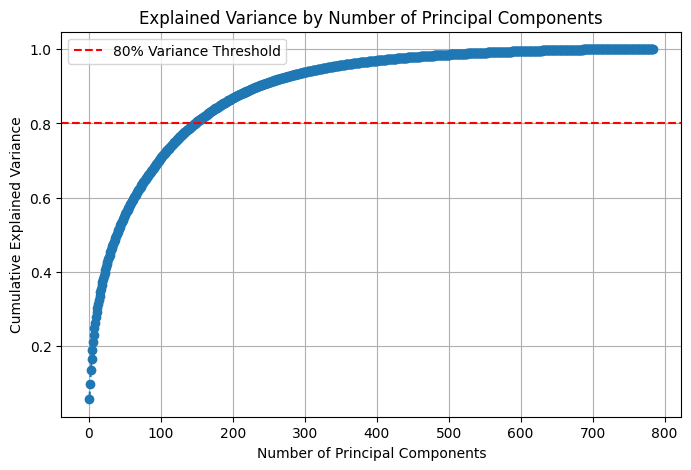

In [20]:
# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.legend(loc='best')
plt.grid()
plt.show()

The **cumulative variance** increases rapidly at the beginning as more principal components are added. However, the rate of increase slows down as additional components contribute smaller amounts of variance. The red dashed line represents the **80% threshold**, and the point where it intersects the curve indicates the number of components required to retain 80% of the variance. The steep curve at the beginning of the graph highlights that a small number of components capture a significant portion of the variance.

###3.3 Visualise the 20 principal components' loadings

This visualisation displays the loadings of the first 20 principal components, reshaped to match the original feature dimensions. Each image corresponds to a principal component and represents the direction in the features space that captures the most variance at that componenet's level.

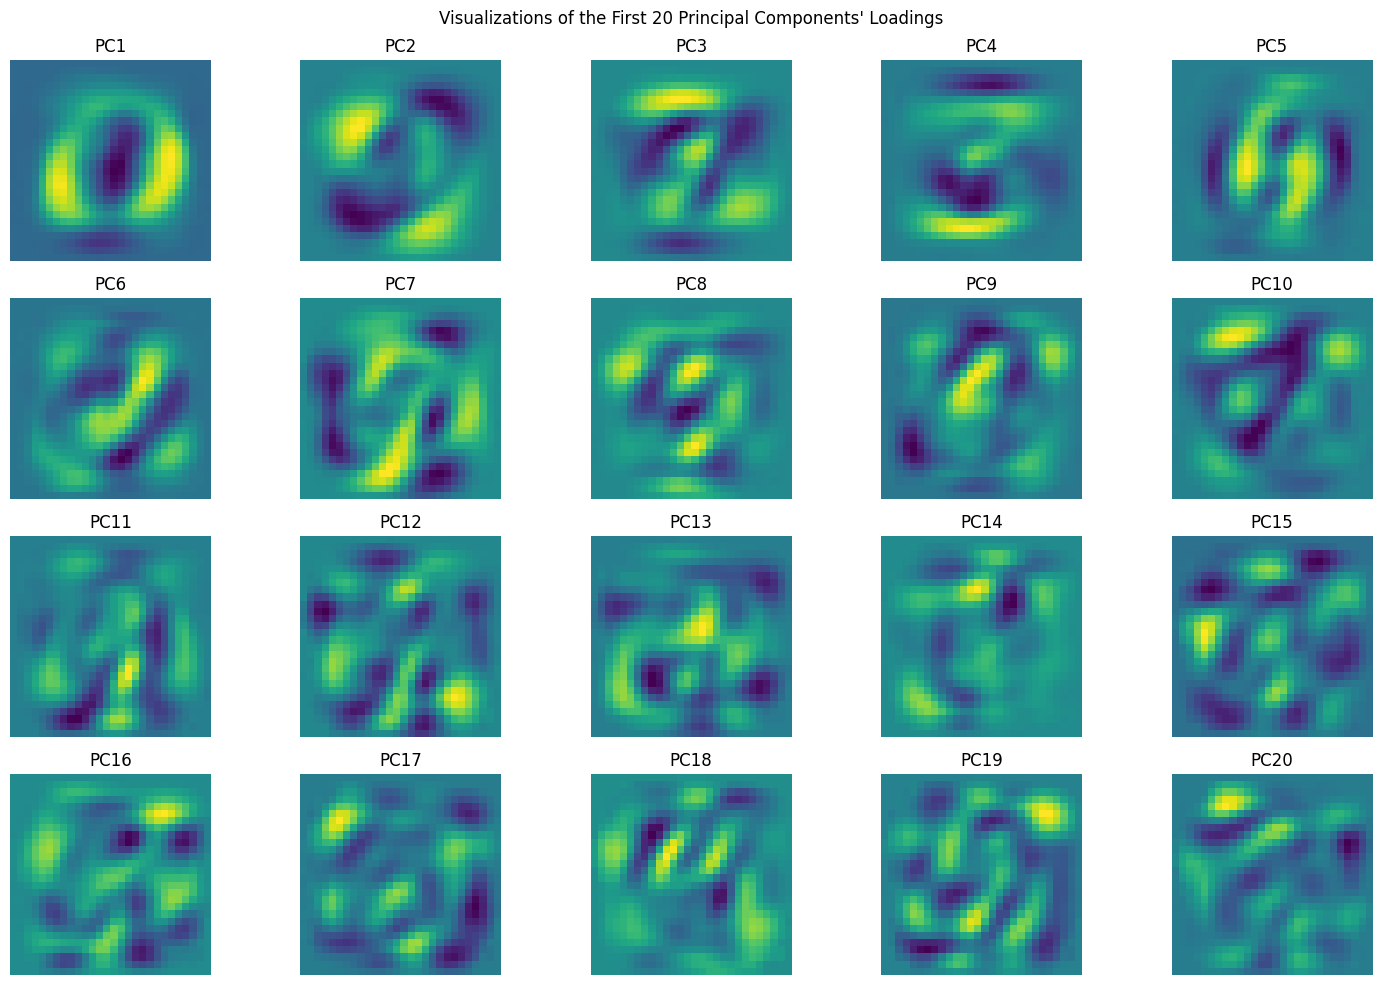

In [21]:
# Fit PCA
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Extract the first 20 principal components' loadings
components = pca_full.components_[:20]

# Reshape each component
components_reshaped = [component.reshape(28, 28) for component in components]

# Plot the components
plt.figure(figsize=(15, 10))
for i, component in enumerate(components_reshaped, 1):
    plt.subplot(4, 5, i)
    plt.imshow(component, cmap='viridis')
    plt.title(f'PC{i}')
    plt.axis('off')

plt.suptitle("Visualizations of the First 20 Principal Components' Loadings")
plt.tight_layout()
plt.show()

The first 20 principal components are plotted using a **heatmap** that visualises which pixels, as features, are most important for each principal component. The first component highlights the most significant pixel patterns, while the other components focus on less important patterns. The brighter yellow areas represent stronger features, which are the most important, while the darker blue areas represent weaker features, which are less important (*Wingate, 2020*). The first principal component captures the most variance in the data. The other components follow in order, capturing progressively smaller amounts of variance. Therefore, the first component is usually the most significant for explaining the structure of the data, as we can see with the first component being the clearest and most easily distinguishable in terms of the number it represents.

###3.4 Plot the two principal components for your data using a scatterplot, colouring by class

This **scatterplot** visualises the first two principal components of the data after performing PCA. Each point in the plot represents a data sample, and the colour of the points corresponds to the class, which in this case is the digit labels. This plot shows how the data is distributed in the reduced 2D space and whether there are any separable clusters or patterns based on the class.

The two axes represent the first and second principal componenets. These components are the directions in the **feature space** that capture the most variance in the data.

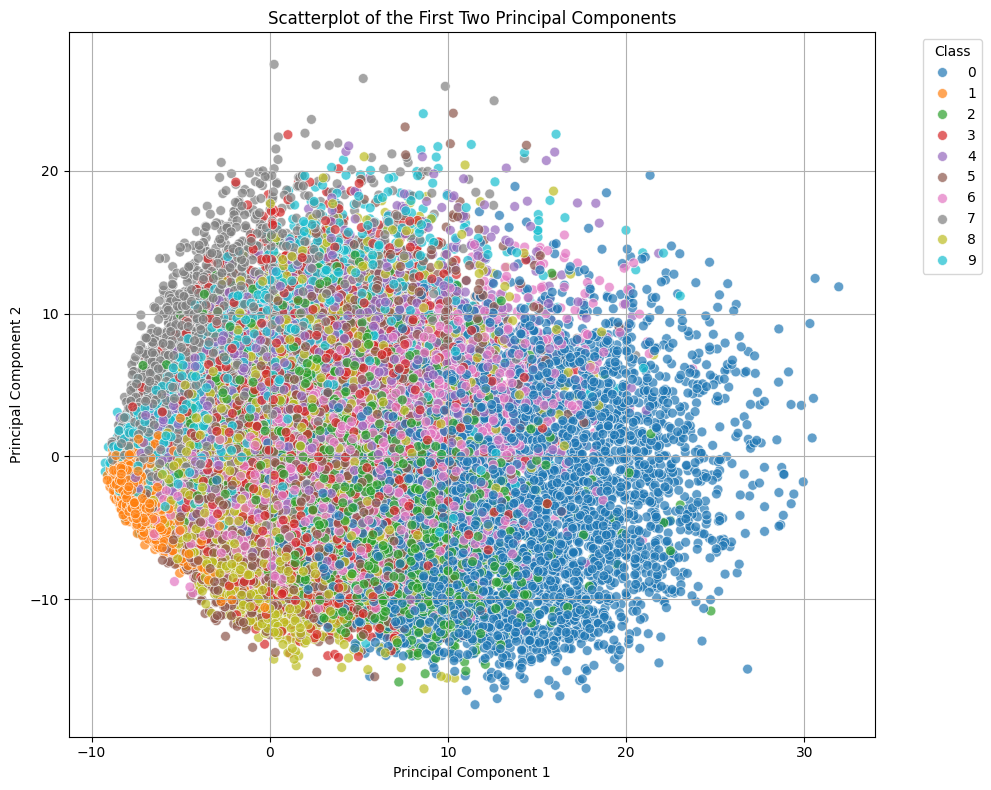

In [22]:
# Fit PCA with 2 components
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_scaled)

# Create a DataFrame for visualization
df_pca = pd.DataFrame(X_pca_2d, columns=['PC1', 'PC2'])
df_pca['Class'] = y_train.astype(int)

# Plot the scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', y='PC2', hue='Class', palette='tab10', data=df_pca, s=50, alpha=0.7
)
plt.title("Scatterplot of the First Two Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

From this plot, we can see that there is very little class separation, with many classes overlapping, especially for digits 3, 9, and 4, which are somewhat difficult to distinguish based on just the first two principal components. We can observe that the most well-defined class is digit 0, which has a distinct, rounded shape and similar patterns across instances.

Overall, while PCA helps to reduce dimensionality, it doesn't fully separate the classes in this high-dimensional dataset. This suggests that for visualisation of datasets like MNIST, PCA may not capture all the details that differentiate the classes. Other techniques, such as t-SNE, might provide clearer separation, as **t-SNE** focuses on preserving the local structure of the data and is particularly effective for visualisation in lower dimensions, such as 2D plots (*singh, 2019*).

###3.5 Visualise the first 20 digits, generated from their lower-dimensional representation

This process involves using PCA to reduce the dimensionality of the MNIST dataset to a smaller number of components that explain 80% of the variance, which was 148 components. Originally, each image in the dataset is represented by 784 features. After applying PCA, each image is now described by a reduced set of components that capture the most significant patterns in the data.

To reconstruct the images, we use PCA's **inverse transform**. This process takes the **lower-dimensional** representation and maps it back to the original feature space. The resulting reconstructed images are approximations of the original images, showing how well PCA can capture the important aspects of the data while ignoring less significant details.

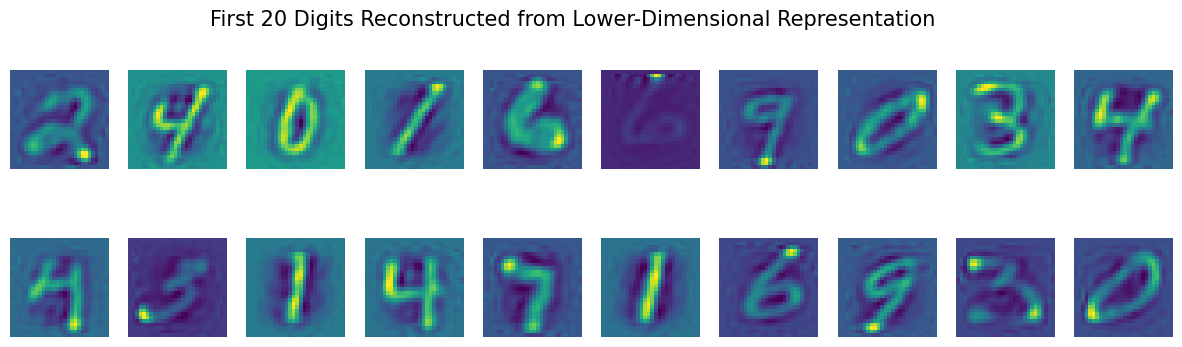

In [23]:
# Visualise the first 20 digits reconstructed from lower-dimensional representation
pca_20 = PCA(n_components=148) # Number of componenets to explain 80% of the variance
X_pca_20 = pca_20.fit_transform(X_train_scaled)
X_reconstructed = pca_20.inverse_transform(X_pca_20)

fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_reconstructed[i].reshape(28, 28), cmap='viridis')
    ax.axis('off')
fig.suptitle("First 20 Digits Reconstructed from Lower-Dimensional Representation", fontsize=15)
plt.show()

From these reconstructed digits, we can see that they still retain their basic structure. The images appear slightly blurred, with some finer details lost due to the limited number of components. However, we can observe that PCA has effectively captured the general features of the data while significantly reducing the dimensionality, using over five times fewer components than originally.

### 4. Generate a noisy copy of your data by adding random normal noise to the digits **with a scale that doesn't completely destroy the signal**. This is, the resulting images noise should be apparent, but the numbers should still be understandable.

We can explore the effect of **noisy data** on digit recognition by adding random noise to the dataset images. This method simulates real-world scenarios where data may be imperfect or inaccurate, often due to distortions during transmission. Before applying noise to the dataset, I scaled the values to ensure each feature contributes equally to the variance. Additionally, when adding noise to the data, scaling ensures the noise has a consistent effect across all feature values.

In [24]:
X_scaled_noise = MinMaxScaler().fit_transform(X)  # Normalize to [0, 1]

# Split dataset into train and test
X_train_noise, X_test_noise, y_train_noise, y_test_noise = train_test_split(X_scaled_noise, y, test_size=0.2, random_state=42)

I added **Gaussian noise** to the dataset with a standard deviation of 0.25. This noise level was chosen to ensure that the digits remain recognisable while the added noise is visually apparent.

In [25]:
# Add Gaussian noise
rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test_noise.shape)
X_test_noisy = X_test_noise + noise
X_train_noisy = X_train_noise + rng.normal(scale=0.25, size=X_train_noise.shape)

###4.1 Visualise the first 20 digits from the noisy dataset

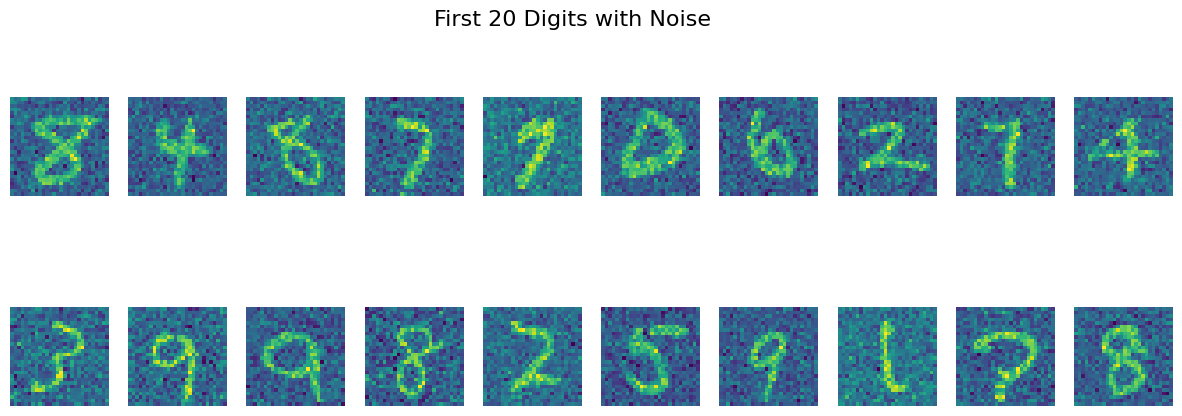

In [26]:
# Visualize the first 20 noisy digits
plt.figure(figsize=(15, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28), cmap='viridis')
    plt.axis('off')
plt.suptitle("First 20 Digits with Noise", fontsize=16)
plt.show()

Gaussian noise has introduced **random pixel intensity variations**. We can visually see this but despite the noise the digit structures still remain recognisable.

###4.2 Filter the noise by fitting a PCA explaining a sufficient proportion of the variance, and then transforming the noisy dataset

To filter out the noise, I applied PCA to the noisy training dataset. To determine the 'sufficient proportion' of components that explain the variance, I referred to the cumulative variance plot from before. For 80% of the variance, the point on the graph aligns with where the curve starts to level off. This indicates the optimal number of components is around this variance.

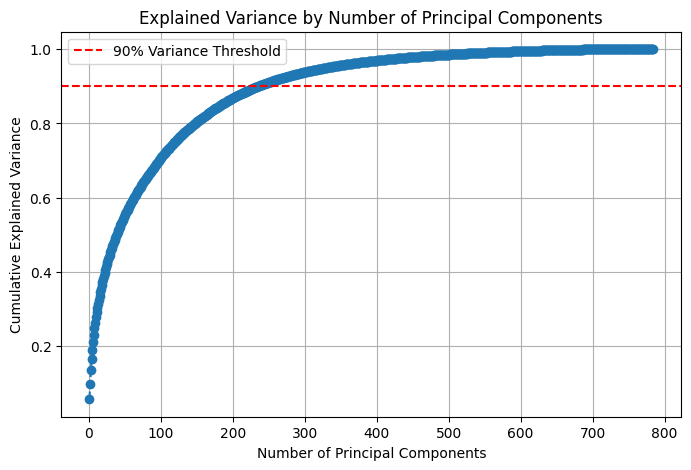

In [27]:
# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Principal Components')
plt.legend(loc='best')
plt.grid()
plt.show()

When I plot the graph for 90% variance, the line intersects the curve at a point where the rapid increase in explained variance begins to level off. This marks the diminishing returns of adding additional components. From this observation, we can determine the number of components required to explain 90% of the variance and apply this number to the PCA. This approach ensures we retain most of the dataset's meaningful information while filtering out noise.

In [28]:
# Perform PCA to reduce dimensionality on the scaled data
pca_scaled = PCA(n_components=0.90)
X_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
print(f'Total number of components used after PCA (scaled) : {pca_scaled.n_components_}')

Total number of components used after PCA (scaled) : 235


In [29]:
# Apply PCA
pca = PCA(n_components=235)
pca.fit(X_train_noisy)

PCA(n_components=235)

In [30]:
# Reconstruct the noisy test images
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

###4.3 Visualise the first 20 digits of the de-noised dataset

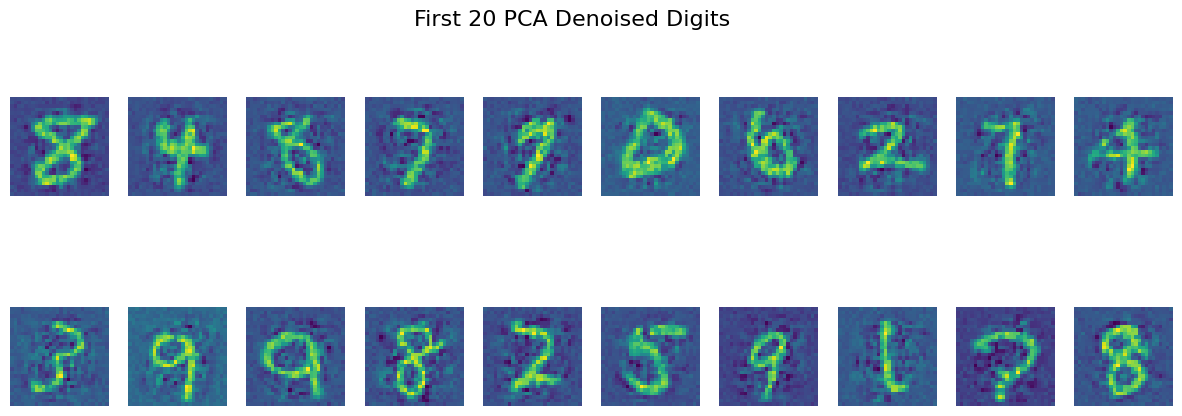

In [31]:
# Plot PCA denoised images for the first 20 digits
plt.figure(figsize=(15, 5))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(X_reconstructed_pca[i].reshape(28, 28), cmap='viridis')
    plt.axis('off')
plt.suptitle("First 20 PCA Denoised Digits", fontsize=16)
plt.show()

By examining the first 20 denoised digits, we observe that while the noise's pixelated look has been softened, the overall structure of the digits remains intact. The denoising process reduces the sharp variations caused by noise, resulting in smoother images. However, this smoothing effect does not eliminate essential features, allowing the digits to still be recognisable. This suggests that PCA effectively filters out noise, but there is a trade-off between removing noise and maintaining the clarity of the digits.

In [32]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between noisy and reconstructed images
mse_pca = mean_squared_error(X_test_noise, X_reconstructed_pca)

print(f'Mean Squared Error for PCA reconstruction: {mse_pca}')

Mean Squared Error for PCA reconstruction: 0.02103277256391601


To assess the effectiveness of the denoising process, I calculated the Mean Squared Error (MSE) between the noisy images and their PCA-reconstructed versions. The MSE value calculated was 0.021, which suggests that the denoising method successfully retained a significant portion of the original image structure while effectively reducing the noise. A relatively low MSE indicates that PCA was efficient in removing the noise and preserving the overall features of the digits.

##Bibliography

1. Analytics Vidhya (2024) *What is Principal Component Analysis (PCA)?*, Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2016/03/pca-practical-guide-principal-component-analysis-python/ (Accessed: 30 November 2024).

2. Baldominos, A., Saez, Y. and Isasi, P. (2019)* 'A survey of handwritten character recognition with mnist and EMNIST', Applied Sciences,* 9(15), pp. 2-3. doi:10.3390/app9153169.

3. Keita, Z. (2023) *Principal Component Analysis (PCA) in R tutorial, DataCamp.* Available at: https://www.datacamp.com/tutorial/pca-analysis-r (Accessed: 30 November 2024).

4. Liashchynskyi, Petro and Liashchynskyi, Pavlo (2019) *Grid Search, Random Search, Genetic Algorithm: A Big Comparison for NAS,* p. 3.
Puri, B. (2023) Mnist dataset for Machine Learning, Medium. Available at: https://medium.com/@binaya.puri/mnist-dataset-for-machine-learning-8987e0b20bb3 (Accessed: 26 November 2024).

5. singh, R. (2019) *Principal component analysis(pca) with code on mnist dataset, Medium.* Available at: https://ranasinghiitkgp.medium.com/principal-component-analysis-pca-with-code-on-mnist-dataset-da7de0d07c22 (Accessed: 01 December 2024).

6. Suhel, R., Humayun, K. and Sobur, A. (2023) *Comparison of the Error Rates of MNIST Datasets Using Different Type of Machine Learning Model,* pp. 175-175. doi:10.5281/zenodo.8010602.

7. Wingate, R. (2020) *Using PCA on Mnist, Ryan Wingate.* Available at: https://ryanwingate.com/intro-to-machine-learning/unsupervised/pca-on-mnist/ (Accessed: 30 November 2024).

8. Yogita (2024) *Guide for building an end-to-end logistic regression model,* Analytics Vidhya. Available at: https://www.analyticsvidhya.com/blog/2021/09/guide-for-building-an-end-to-end-logistic-regression-model/ (Accessed: 29 November 2024).